In [1]:
import zipfile
import os
 
file=zipfile.ZipFile('Reverse.zip','r')
file.extractall(os.getcwd())
file.close()


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import zipfile
import pandas as pd
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

zip_path = 'Reverse.zip'
final_df = pd.DataFrame()

with zipfile.ZipFile(zip_path, 'r') as archive:
    zip_contents = archive.namelist()
    zip_contents=zip_contents[1:]
    # 遍历每个文件夹
    for folder_name in zip_contents:  
        # 读取当前文件夹中的 tf.csv 文件
        if folder_name.endswith('/'):
            # 提取文件夹编号
            folder_number = folder_name.rstrip('/')
            # 读取该文件夹中的 CSV 文件
            csv_file_path = f'{folder_name}rev.csv'
            with archive.open(csv_file_path) as csv_file:
                # 使用 pandas 读取 CSV 文件
                df = pd.read_csv(csv_file)
                date=str(folder_name)[-11:-1].replace('.', '')
                df['date']=date
                df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
                if df.empty:
                    final_df = df
                else:
                    final_df=pd.concat([final_df, df], axis=0, ignore_index=True)
                    
final_df.to_csv('Reverse.csv')

In [40]:
final_df=final_df.rename(columns={'stock':'WindCode'})
final_df.to_csv('Reverse.csv')
final_df.head(5)

,Unnamed: 0,WindCode,Ask_1,Ask_2,Ask_3,Ask_4,Ask_5,Ask_6,Ask_7,Ask_8,...,Bid_7,Bid_8,Bid_9,Bid_10,Bid_11,Bid_12,Bid_13,Bid_14,Bid_15,date
0,0,000001.SZ,1298683,2088960.0,3375453.0,4501835.0,5702323.0,7155007.0,8404039.0,9555876.0,...,8216161.0,9497387.0,10402063.0,11249212.0,12342869.0,13510089.0,14583104.0,15829094.0,17032457.0,2020-05-13
1,1,000002.SZ,1366690,2728175.0,4272797.0,5643958.0,6223639.0,6795903.0,8178810.0,8993529.0,...,7875494.0,8875377.0,9708115.0,11075397.0,12095360.0,13382961.0,14599152.0,15983854.0,17033726.0,2020-05-13
2,2,000004.SZ,893970,1496211.0,2156364.0,2484529.0,2845375.0,3218821.0,3800682.0,4621433.0,...,4226102.0,5602248.0,6252347.0,6600466.0,7663139.0,8144570.0,8183620.0,8747984.0,8842377.0,2020-05-13
3,3,000005.SZ,855286,2440543.0,3495837.0,4724856.0,5754787.0,7221757.0,8180429.0,9026818.0,...,8159332.0,9699720.0,10707533.0,11708443.0,12019717.0,13556911.0,14495325.0,15700026.0,16689230.0,2020-05-13
4,4,000006.SZ,1534048,2128882.0,3263840.0,4602168.0,6079209.0,7366782.0,8425267.0,9303922.0,...,8814884.0,9494738.0,9975251.0,10947341.0,12199327.0,13399819.0,14877935.0,15872823.0,17032860.0,2020-05-13


In [34]:
st_c=pd.read_csv('close.csv')
st_o=pd.read_csv('open.csv')
st=pd.merge(st_c,st_o,on=['date','WindCode'])
st['date']=pd.to_datetime(st['date'])
sk=st.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'])

In [35]:
def close_ret(group,period=-1,name='D'):
    # month -> period = -20
    # day -> period = -1
    group['next']=group['close'].shift(period)
    group[name+'close_ret']=group['next']/group['close']-1
    return group

def open_ret(group,period=-1,name='D'):
    # month -> period = -20
    # day -> period = -1
    group['next']=group['close'].shift(period)
    group['opn']=group['open'].shift(-1)
    group[name+'open_ret']=group['next']/group['opn']-1
    return group
st=sk
st=st.groupby('WindCode').apply(lambda x:close_ret(x,-1,'D')).drop(columns='WindCode').reset_index().drop(columns='level_1')
st=st.groupby('WindCode').apply(lambda x:open_ret(x,-1,'D')).drop(columns='WindCode').reset_index().drop(columns='level_1')
st=st.groupby('WindCode').apply(lambda x:close_ret(x,-5,'W')).drop(columns='WindCode').reset_index().drop(columns='level_1')
st=st.groupby('WindCode').apply(lambda x:close_ret(x,-10,'2W')).drop(columns='WindCode').reset_index().drop(columns='level_1')
st=st.groupby('WindCode').apply(lambda x:close_ret(x,-20,'M')).drop(columns='WindCode').reset_index().drop(columns='level_1')

In [38]:

st['ret']=st.groupby('WindCode')['Dclose_ret'].transform(lambda x:x.shift(1))

In [42]:
final_df=pd.read_csv('Reverse.csv')
final_df['date']=pd.to_datetime(final_df['date'])
df_SD=pd.merge(st,final_df,on=['date','WindCode'])
df_SD.to_csv('FacSlice_SD.csv')

In [27]:
df_SD.head(5)

,WindCode,date,close,open,next,Dclose_ret,opn,Dopen_ret,Wclose_ret,2Wclose_ret,...,Bid_6,Bid_7,Bid_8,Bid_9,Bid_10,Bid_11,Bid_12,Bid_13,Bid_14,Bid_15
0,000001.SZ,2015-01-05,1305.982784,1303.537123,1111.145153,-0.014981,1292.124040,-0.004416,-0.078027,-0.136704,...,944297.0,1199714.0,1354342.0,1504260.0,1653080.0,1722590.0,1803245.0,1899362.0,1972427.0,2106092.0
1,000001.SZ,2015-01-06,1286.417499,1292.124040,1137.232200,-0.019011,1268.482654,-0.005141,-0.069708,-0.123574,...,832561.0,930111.0,1042253.0,1211441.0,1317277.0,1464183.0,1666794.0,1848574.0,2061637.0,2271564.0
2,000001.SZ,2015-01-07,1261.960892,1268.482654,1117.666914,-0.033592,1263.591333,-0.034839,-0.043282,-0.068475,...,775580.0,915204.0,1062418.0,1159581.0,1262106.0,1360418.0,1451819.0,1577571.0,1704785.0,1817213.0
3,000001.SZ,2015-01-08,1219.569441,1263.591333,1124.188676,0.008021,1214.678120,0.012081,0.026070,-0.044118,...,708548.0,824199.0,951877.0,1109419.0,1249266.0,1401430.0,1543063.0,1673696.0,1795895.0,1908365.0
4,000001.SZ,2015-01-09,1229.352084,1214.678120,1101.362510,-0.020557,1212.232459,-0.006725,0.019231,-0.045093,...,1241459.0,1307483.0,1375905.0,1456708.0,1508321.0,1559070.0,1615316.0,1709235.0,1822704.0,1929469.0


## 开始探究

### 构建因子

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('FacSlice_SD.csv')
df['date']=pd.to_datetime(df['date'])
df_o=df

In [14]:
df=df_o.dropna()
df['time']=df['date']
df['ticker']=df['WindCode']

df=df.set_index('date')
df=df.sort_values(by='date')

def factor(group,kind='Ask_15'):
    if group.empty:
        return pd.DataFrame({
            'M_High': [None],
            'M_Low': [None],
            'M': [None],
            'return': [None]
        })
        
    m=group[kind].median()
    M_High=group.loc[group[kind]>m,'ret'].sum()
    M_Low=group.loc[group[kind]<m,'ret'].sum()
    #print(group[['Mclose_ret','time','ticker']])
    ret=group['Mclose_ret'].iloc[-1] #月末调仓
    prev_ret=group['Mclose_ret'].iloc[0]
    result = pd.DataFrame({
        'M_High': [M_High],
        'M_Low': [M_Low],
        'M': [M_High-M_Low],
        'return':[ret],
        'prev':[prev_ret]
    })
    return result

df['ret']=df.groupby('WindCode')['close'].transform(lambda x:x.pct_change()) #当日return：今日close/昨日close

dt_A_15=df.groupby('WindCode').resample('M').apply(factor,'Ask_15').reset_index()

In [16]:
dt_A_15.head(5)

,WindCode,level_1,M_High,M_Low,M,return
0,000001.SZ,0,-0.012812,-0.108458,0.095646,-0.035176
1,000001.SZ,0,0.033954,-0.011017,0.044971,0.077913
2,000001.SZ,0,-0.005275,0.129781,-0.135056,0.279777
3,000001.SZ,0,0.049876,0.215301,-0.165424,-0.082635
4,000001.SZ,0,-0.019201,-0.062418,0.043218,-0.114883


In [17]:
def IC(group,factor,ret):
    ic=group[factor].corr(group[ret])
    return ic
    
dt_A_15_IC=dt_A_15.groupby('WindCode').apply(IC,'M','return')
dt_A_15_IC.mean()

-0.0631314602359149

### 整个ask和bid的所有分为点观察（Monthly）

Data has been processed.


Outer Loop: 100%|████████████████████████████| 15/15 [1:59:52<00:00, 479.49s/it]


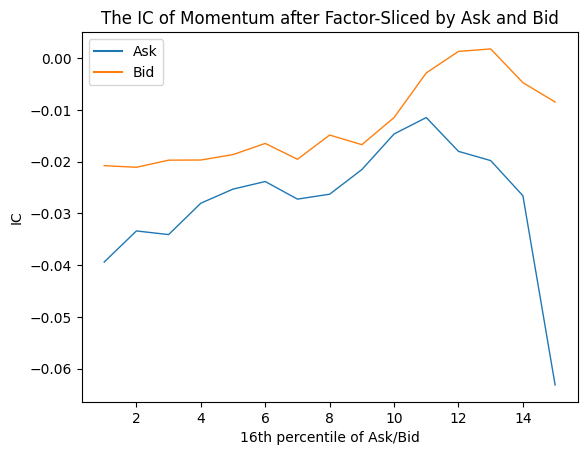

In [32]:
from tqdm import tqdm

df=df_o.dropna()
df=df.set_index('date')
df=df.sort_values(by='date')
df['ret']=df.groupby('WindCode')['close'].transform(lambda x:x.pct_change()) #当日return：今日close/昨日close
print('Data has been processed.')

def IC(group,factor,ret):
    ic=group[factor].corr(group[ret])
    return ic

def _factor(group,kind='Ask_15'):
    if group.empty:
        return pd.DataFrame({
            'M_High': [None],
            'M_Low': [None],
            'M': [None],
            'return': [None]
        })
        
    m=group[kind].median()
    M_High=group.loc[group[kind]>m,'ret'].sum()
    M_Low=group.loc[group[kind]<m,'ret'].sum()
    #print(group[['Mclose_ret','time','ticker']])
    ret=group['Mclose_ret'].iloc[-1] #月末调仓
    result = pd.DataFrame({
        'M_High': [M_High],
        'M_Low': [M_Low],
        'M': [M_High-M_Low],
        'return':[ret]})
    return result

dic={'name':[],'IC':[],'order_type':[]}
for i in tqdm(range(1,16), desc="Outer Loop"):
    for order in ['Ask','Bid']:
    #for order in ['Ask','Bid']:
        kind=order+'_'+str(i)
        ndf=df[['WindCode',kind,'ret','Mclose_ret']]
        dt_order_i=ndf.groupby('WindCode').resample('M').apply(factor,kind).reset_index()
        dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC,'M','return')
        dic['name']+=[i]
        dic['order_type']+=[order]
        dic['IC']+=[dt_order_i_IC.mean()]
        #print(order_type+' has been completed.')


IC_df=pd.DataFrame(dic)
sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
plt.legend()
plt.xlabel('16th percentile of Ask/Bid')
plt.title('The IC of Momentum after Factor-Sliced by Ask and Bid')
plt.show()

In [7]:
from tqdm import tqdm
df=df_o.dropna()
df=df.set_index('date')
df=df.sort_values(by='date')
df['ret']=df.groupby('WindCode')['close'].transform(lambda x:x.pct_change()) #当日return：今日close/昨日close
print('Data has been processed.')

Data has been processed.


#### 绘制M_High和M_Low的IC（区分不同趋势下）

In [12]:
def _factor(group,kind='Ask_15'):
    if group.empty:
        return pd.DataFrame({
            'M_High': [None],
            'M_Low': [None],
            'M': [None],
            'return': [None]
        })
        
    m=group[kind].median()
    M_High=group.loc[group[kind]>m,'ret'].sum()
    M_Low=group.loc[group[kind]<m,'ret'].sum()
    #print(group[['Mclose_ret','time','ticker']])
    ret=group['Mclose_ret'].iloc[-1] #月末调仓
    result = pd.DataFrame({
        'M_High': [M_High],
        'M_Low': [M_Low],
        'M': [M_High-M_Low],
        'return':[ret]})
    return result

In [13]:
dic={'name':[],'IC':[],'order_type':[]}
for order in tqdm(['Ask','Bid'],desc="Outer Loop"):
    for i in tqdm(range(1,16),desc="Inner Loop",leave=False):
        for corr in ['M_High','M_Low']:
            kind=order+'_'+str(i)
            ndf=df[['WindCode',kind,'ret','Mclose_ret']]
            dt_order_i=ndf.groupby('WindCode').resample('M').apply(lambda x:_factor(x,kind)).reset_index()
            dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC,corr,'return')
            dic['name']+=[i]
            dic['order_type']+=[corr]
            dic['IC']+=[dt_order_i_IC.mean()]
    
    IC_df=pd.DataFrame(dic)
    sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
    plt.legend()
    plt.title('This is the '+order+' IC of M_High and M_Low')
    plt.show()

Outer Loop:   0%|                                         | 0/2 [03:52<?, ?it/s]


NameError: name 'IC' is not defined

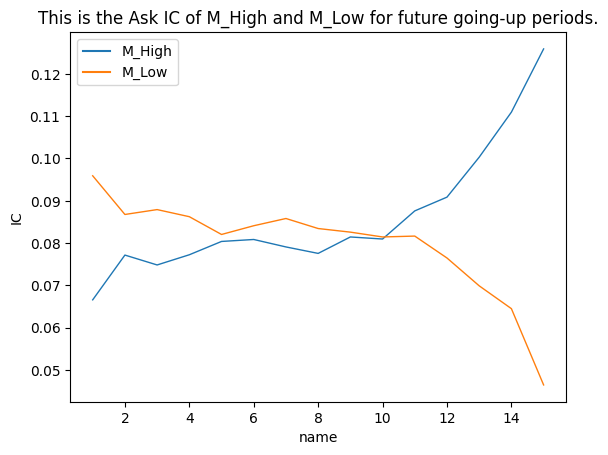

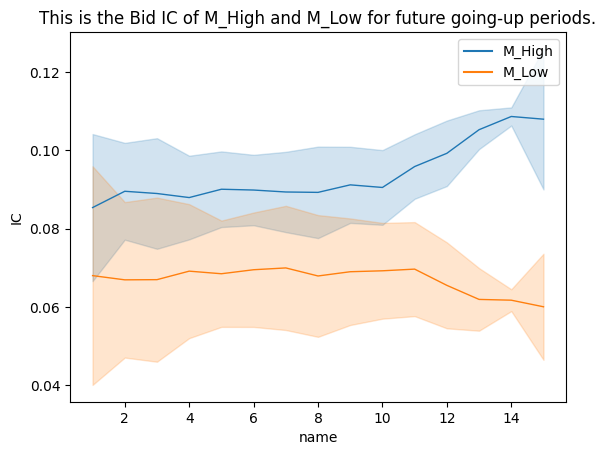

In [35]:
def IC_up(group,factor,ret):
    group=group[group[ret]>0]
    ic=group[factor].corr(group[ret])
    return ic
    
dic={'name':[],'IC':[],'order_type':[]}
for order in ['Ask','Bid']:
    for i in tqdm(range(1,16),desc="2 Outer Loop",leave=False):
        for corr in ['M_High','M_Low']:
            kind=order+'_'+str(i)
            ndf=df[['WindCode',kind,'ret','Mclose_ret']]
            dt_order_i=ndf.groupby('WindCode').resample('M').apply(factor,kind).reset_index()
            dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC_up,corr,'return')
            dic['name']+=[i]
            dic['order_type']+=[corr]
            dic['IC']+=[dt_order_i_IC.mean()]
    
    IC_df=pd.DataFrame(dic)
    sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
    plt.legend()
    plt.title('This is the '+order+' IC of M_High and M_Low for future going-up periods.')
    plt.show()

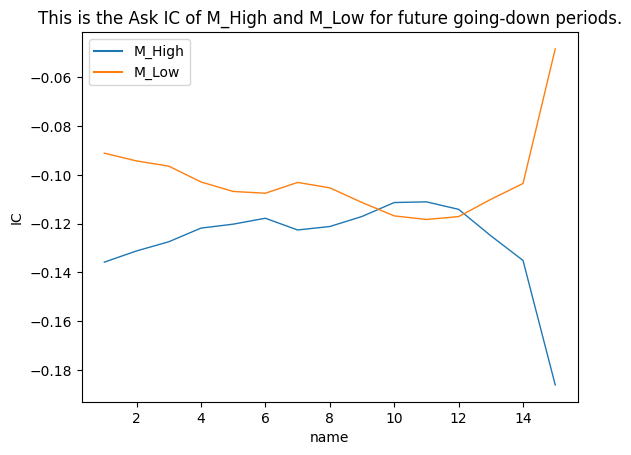

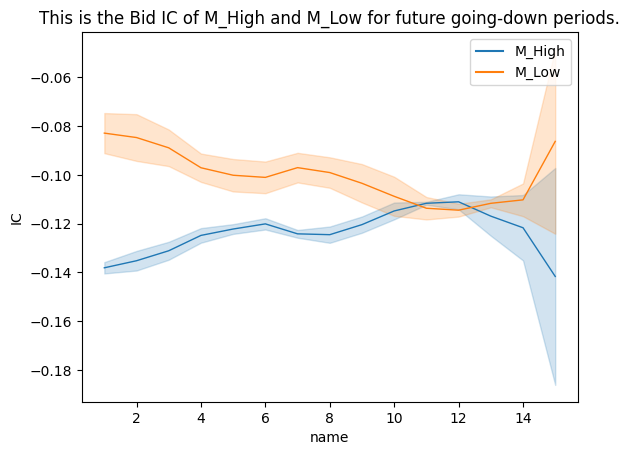

In [36]:
def IC_down(group,factor,ret):
    group=group[group[ret]<0]
    ic=group[factor].corr(group[ret])
    return ic
    
dic={'name':[],'IC':[],'order_type':[]}
for order in ['Ask','Bid']:
    for i in tqdm(range(1,16),desc="2 Outer Loop",leave=False):
        for corr in ['M_High','M_Low']:
            kind=order+'_'+str(i)
            ndf=df[['WindCode',kind,'ret','Mclose_ret']]
            dt_order_i=ndf.groupby('WindCode').resample('M').apply(factor,kind).reset_index()
            dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC_down,corr,'return')
            dic['name']+=[i]
            dic['order_type']+=[corr]
            dic['IC']+=[dt_order_i_IC.mean()]
    
    IC_df=pd.DataFrame(dic)
    sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
    plt.legend()
    plt.title('This is the '+order+' IC of M_High and M_Low for future going-down periods.')
    plt.show()

### IC for prev ret

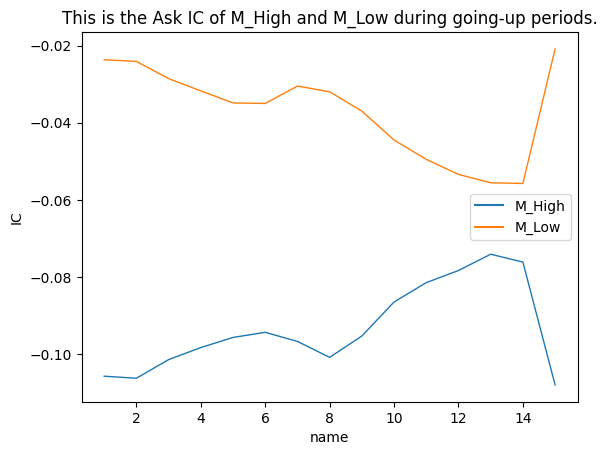

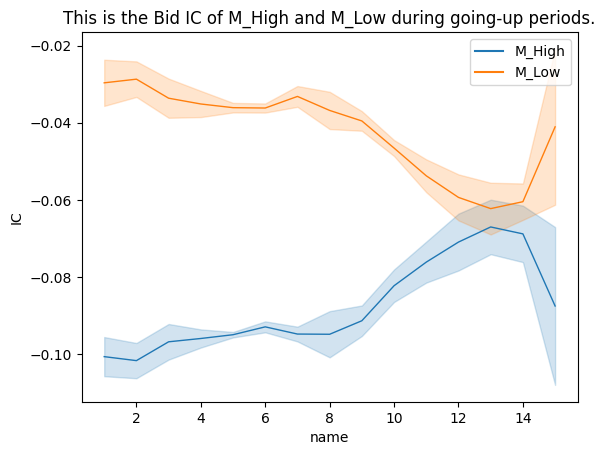

In [37]:
def factor(group,kind='Ask_15'):
    if group.empty:
        return pd.DataFrame({
            'M_High': [None],
            'M_Low': [None],
            'M': [None],
            'return': [None]
        })
        
    m=group[kind].median()
    M_High=group.loc[group[kind]>m,'ret'].sum()
    M_Low=group.loc[group[kind]<m,'ret'].sum()
    #print(group[['Mclose_ret','time','ticker']])
    ret=group['Mclose_ret'].iloc[-1] #月末调仓
    prev_ret=group['Mclose_ret'].iloc[0]
    result = pd.DataFrame({
        'M_High': [M_High],
        'M_Low': [M_Low],
        'M': [M_High-M_Low],
        'return':[ret],
        'prev':[prev_ret]
    })
    return result
    
def IC_up_p(group,factor,ret,prev):
    group=group[group[prev]>0]
    ic=group[factor].corr(group[ret])
    return ic
    
dic={'name':[],'IC':[],'order_type':[]}
for order in ['Ask','Bid']:
    for i in tqdm(range(1,16),desc="2 Outer Loop",leave=False):
        for corr in ['M_High','M_Low']:
            kind=order+'_'+str(i)
            ndf=df[['WindCode',kind,'ret','Mclose_ret']]
            dt_order_i=ndf.groupby('WindCode').resample('M').apply(factor,kind).reset_index()
            dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC_up_p,corr,'return','prev')
            dic['name']+=[i]
            dic['order_type']+=[corr]
            dic['IC']+=[dt_order_i_IC.mean()]
    
    IC_df=pd.DataFrame(dic)
    sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
    plt.legend()
    plt.title('This is the '+order+' IC of M_High and M_Low during going-up periods.')
    plt.show()

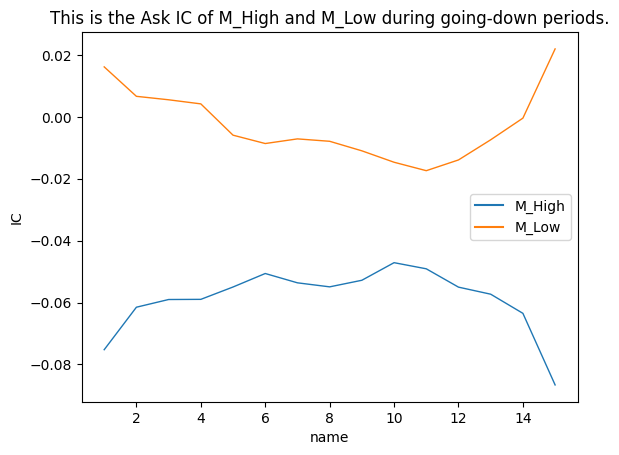

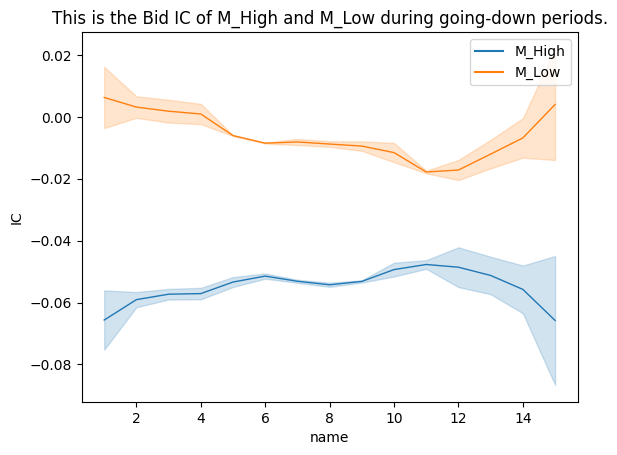

In [38]:
def IC_down_p(group,factor,ret,prev):
    group=group[group[prev]<0]
    ic=group[factor].corr(group[ret])
    return ic
    
dic={'name':[],'IC':[],'order_type':[]}
for order in ['Ask','Bid']:
    for i in tqdm(range(1,16),desc="2 Outer Loop",leave=False):
        for corr in ['M_High','M_Low']:
            kind=order+'_'+str(i)
            ndf=df[['WindCode',kind,'ret','Mclose_ret']]
            dt_order_i=ndf.groupby('WindCode').resample('M').apply(factor,kind).reset_index()
            dt_order_i_IC=dt_order_i.groupby('WindCode').apply(IC_down_p,corr,'return','prev')
            dic['name']+=[i]
            dic['order_type']+=[corr]
            dic['IC']+=[dt_order_i_IC.mean()]
    
    IC_df=pd.DataFrame(dic)
    sns.lineplot(data=IC_df,x='name',y='IC',hue='order_type',lw=1)
    plt.legend()
    plt.title('This is the '+order+' IC of M_High and M_Low during going-down periods.')
    plt.show()

## Net
#### benchmark: Ret20; strat: 1.M;2.M+Ret20;3.M+M_High

Data has been processed.


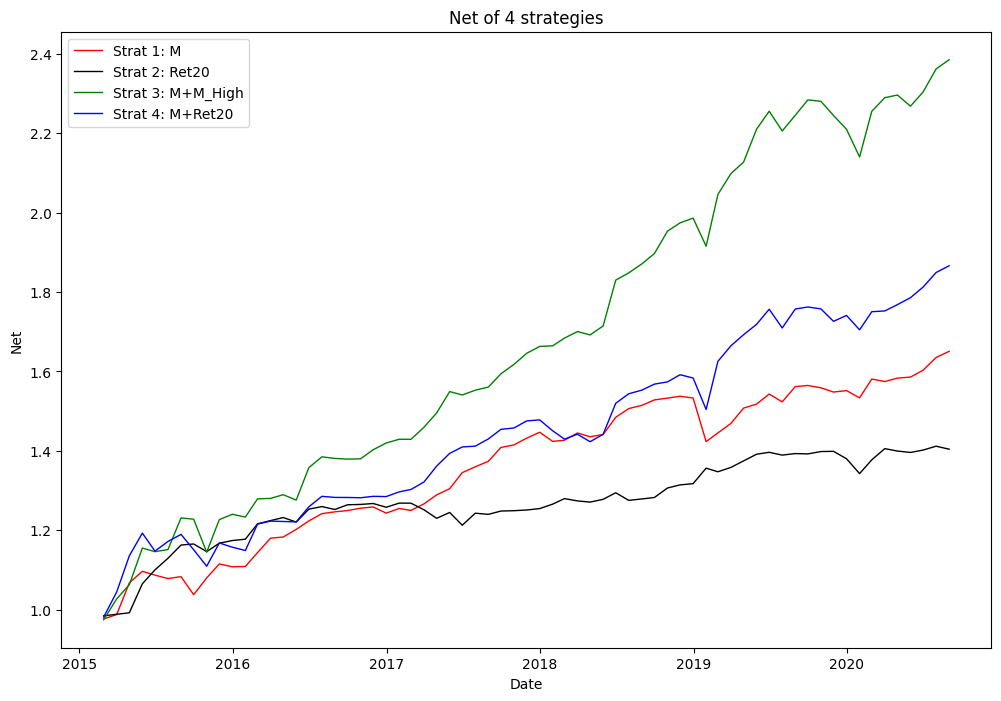

In [85]:
df=df_o.dropna()
df=df.sort_values(by='date')
df['ret']=df.groupby('WindCode')['close'].transform(lambda x:x.pct_change()) 
df['time']=df['date']
df['date'] = df['date'] + pd.offsets.MonthEnd(0) #date: end of the month's date
df=df.set_index('time')
print('Data has been processed.')

def _factor(group,kind='Ask_15'):
    if group.empty:
        return pd.DataFrame({
            'M_High': [None],
            'M_Low': [None],
            'M': [None],
            #'return': [None],
            'Ret20':[None],
            'prev':[None],
            'date':[None]
        })
    m=group[kind].median()
    M_High=group.loc[group[kind]>m,'ret'].sum()
    M_Low=group.loc[group[kind]<m,'ret'].sum()
    #print(group[['Mclose_ret','time','ticker']])
    ret=(group['close'].iloc[-1])/(group['prev_close'].iloc[0])-1 #月末调仓
    #prev_ret=group['Mclose_ret'].iloc[0]
    result = pd.DataFrame({
        'M_High': [M_High],
        'M_Low': [M_Low],
        'M': [M_High-M_Low],
        #'return':[ret],
        'Ret20':[ret], #看着Momentum效应更强啊？
        'prev':[ret],
        'date':[group['date'].iloc[-1]]
    })
    return result
    
def bin_ret(group,factor):
    group['rk'] = group[factor].rank(method='first')
    group['bin'] = pd.qcut(group['rk'], q=5, labels=[1, 2, 3, 4, 5])
    group=group.drop(columns='rk')
    a=group.groupby('bin')['return'].mean().reset_index() #每个bin的平均收益
    #return a.loc[a['bin']==1,'return'].iloc[0]-a.loc[a['bin']==5,'return'].iloc[0]
    if factor == 'M':
        return a.loc[a['bin']==2,'return'].iloc[0]-a.loc[a['bin']==5,'return'].iloc[0]
    else:
        return (a.loc[a['bin']==1,'return'].iloc[0]-a.loc[a['bin']==5,'return'].iloc[0])/3 #######

def combo(group,factor='Ret20'):
    neg=group[group['prev']<0]
    pos=group[group['prev']>0]
    #for M
    neg['rk'] = neg['M'].rank(method='first')
    neg['bin'] = pd.qcut(neg['rk'], q=5, labels=[1, 2, 3, 4, 5])
    a=neg.groupby('bin')['return'].mean().reset_index()
    M_ret=a.loc[a['bin']==2,'return'].iloc[0]-a.loc[a['bin']==5,'return'].iloc[0]
    #for another
    pos['rk'] = pos[factor].rank(method='first')
    pos['bin'] = pd.qcut(pos['rk'], q=5, labels=[1, 2, 3, 4, 5])
    a=pos.groupby('bin')['return'].mean().reset_index()
    pos_ret=a.loc[a['bin']==1,'return'].iloc[0]-a.loc[a['bin']==5,'return'].iloc[0]
    return (pos_ret+M_ret)/2

#重写Mclose_ret
df=df.sort_index()
df['prev_close']=df.groupby('WindCode')['close'].transform(lambda x:x.shift(1))   
ndf=df[['WindCode','Ask_15','ret','Mclose_ret','date','close','prev_close']]
ndf=ndf.groupby('WindCode').resample('M').apply(_factor,'Ask_15').reset_index()
ndf['return']=ndf.groupby('WindCode')['prev'].transform(lambda x : x.shift(-1))
ndf=ndf.dropna()
for factor in ['M','Ret20']:
    if factor=='M':
        mdf=ndf.groupby('date').apply(bin_ret,factor).reset_index()
        mdf=mdf.rename(columns={0:'M_ret'})
    else:
        temp=ndf.groupby('date').apply(bin_ret,factor).reset_index()
        temp=temp.rename(columns={0:'Ret20_ret'})
        mdf=pd.merge(mdf,temp,on='date')
        
ndf=ndf.dropna()        
for factor in ['Ret20','M_High']:
    temp=ndf.groupby(['date']).apply(combo,factor).reset_index().rename(columns={0:'M+'+factor+'_ret'})
    mdf=pd.merge(mdf,temp,on='date')

mdf=mdf.sort_values(by='date')
for item in ['M_ret','Ret20_ret','M+Ret20_ret','M+M_High_ret']:
    mdf[item+'_net_o']=(mdf[item]+1).cumprod()
    mdf[item+'_net']=np.log(mdf[item+'_net_o'])

plt.figure(figsize=(12, 8))
i=0
colors=['r','k','g','b']
legends=['Strat 1: M','Strat 2: Ret20','Strat 3: M+M_High','Strat 4: M+Ret20']
for item in ['M_ret','Ret20_ret','M+Ret20_ret','M+M_High_ret']:
    sns.lineplot(data=mdf,x='date',y=item+'_net_o',lw=1,color=colors[i],label=legends[i])
    i+=1
plt.ylabel('Net')
plt.xlabel('Date')
plt.title('Net of 4 strategies')
plt.legend()
plt.show()